In [1]:
from IPython.core.display import display, HTML
import random
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
from tqdm import tqdm

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [4]:
from functools import partial

import torch

from pyro.nn import AutoRegressiveNN, ConditionalAutoRegressiveNN

from pyro.distributions import constraints
from pyro.distributions.conditional import ConditionalTransformModule
from pyro.distributions.torch_transform import TransformModule
from pyro.distributions.util import copy_docs_from
from pyro.distributions.transforms import SplineCoupling
from pyro.distributions.transforms.spline import ConditionalSpline



import numpy as np
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
#from data_utils.data_loader import HDF5Dataset, MaxwellBatchLoader, MaxwellBatchLoaderFullyCond


#import ML_models.models as models
#import ML_models.functions as functions
import time
import h5py

from custom_pyro import ConditionalAffineCouplingTanH

from pyro.nn import ConditionalDenseNN, DenseNN, ConditionalAutoRegressiveNN
import pyro.distributions as dist
import pyro.distributions.transforms as T
device = torch.device('cuda:0')

In [5]:
def compile_HybridTanH_model(num_blocks, num_inputs, num_cond_inputs, device):
    # the latent space distribution: choosing a 2-dim Gaussian
    base_dist = dist.Normal(torch.zeros(num_inputs).to(device), torch.ones(num_inputs).to(device))

    input_dim = num_inputs
    count_bins = 8
    transforms = []
    transforms2 = []
      
    input_dim = num_inputs
    split_dim = num_inputs//2
    param_dims1 = [input_dim-split_dim, input_dim-split_dim]
    param_dims2 = [input_dim * count_bins, input_dim * count_bins, input_dim * (count_bins - 1), input_dim * count_bins]

    torch.manual_seed(42)

    for i in range(num_blocks):
        

                    
        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)
        
        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)

        
        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)

        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)

        
        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)
        
        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)
        
        
        
        
        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)
        
        hypernet = DenseNN(num_cond_inputs, [input_dim*4, input_dim*4], param_dims2)
        ctf = T.ConditionalSpline(hypernet, input_dim, count_bins)
        transforms2.append(ctf)
        transforms.append(ctf)
        

        

        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)
        
        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)

        
        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)

        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)

        
        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)
        
        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)
        
        
        
        
        
    modules = nn.ModuleList(transforms2)

    flow_dist = dist.ConditionalTransformedDistribution(base_dist, transforms)

    return modules, flow_dist

In [56]:
num_blocks = 10

In [57]:
# num_inputs: visible_energy 1 + num_points (total) 1 + e_per_layer (normalized [0, 1]) 45, num_point_per_layer (normalized [0, 1]) 45 = 92
model, distribution = compile_HybridTanH_model(num_blocks, 
                                           num_inputs=92, ### when 'condioning' on additional Esum, Nhits etc add them on as inputs rather than 
                                           num_cond_inputs=1, device=device)  # num_cond_inputs

In [8]:
default_params = {
    "batch_size" : 512,
    "epochs" : 500, # 138 epochs with lr 5e-5, then to 300 epochs with lr 1e-5 and to 500 with 5e-6
    "shuffle" : True,
}

In [9]:
kwargs = {}
params = {}
for param in default_params.keys():

    if param in kwargs.keys():
        params[param] = kwargs[param]
    else:
        params[param] = default_params[param]

In [10]:
path = '/beegfs/desy/user/akorol/data/calo-challange/dataset_3_xyz_tarin.hdf5'
energy = h5py.File(path, 'r')['energy'][-93060:]
events = h5py.File(path, 'r')['events'][-93060:]

num_points = (events[:][:, -1] > 0).sum(axis=1)
visible_energy = (events[:][:, -1]).sum(axis=1)

In [64]:
# for validation
visible_energy_true = (events[:][:, -1]).sum(axis=1)
num_points_true = (events[:][:, -1] > 0).sum(axis=1)
energy_true = h5py.File(path, 'r')['energy'][-93060:]

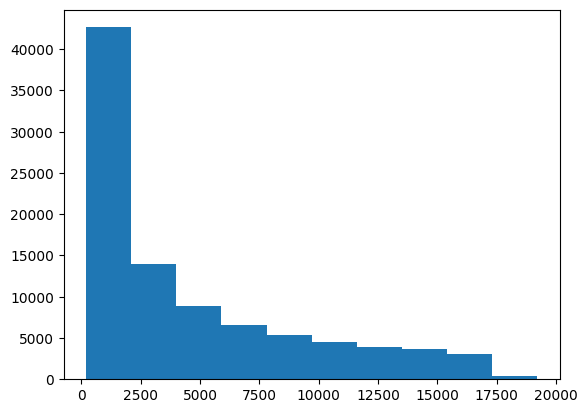

In [14]:
plt.hist(num_points)
plt.show()

In [15]:
num_points.max()

19206

In [150]:
# takes some time to run this, calculate it onces and then save as numpy

clusters_per_layer = []
for i in tqdm(range(45)):
    clusters_per_layer.append( ((events[:, 2, :] < i+1) & (events[:, 2, :] > i)).sum(axis=1) )

clusters_per_layer = np.vstack(clusters_per_layer)
clusters_per_layer = np.moveaxis(clusters_per_layer, 0, -1)

e_per_layer = []
for i in tqdm(range(45)):
    layer_mask = (events[:, 2, :] < i+1) & (events[:, 2, :] > i)
    e_per_layer.append( (events[:, -1, :] * layer_mask).sum(axis=1) )
    

e_per_layer = np.vstack(e_per_layer)
e_per_layer = np.moveaxis(e_per_layer, 0, -1)

100%|██████████| 45/45 [03:50<00:00,  5.13s/it]


In [153]:
# save 
np.save('e_per_layer.npy', e_per_layer)
np.save('clusters_per_layer.npy', clusters_per_layer)

In [18]:
# load precalculated
e_per_layer = np.load('e_per_layer.npy')
clusters_per_layer = np.load('clusters_per_layer.npy')


In [19]:
clusters_per_layer.shape

(93060, 45)

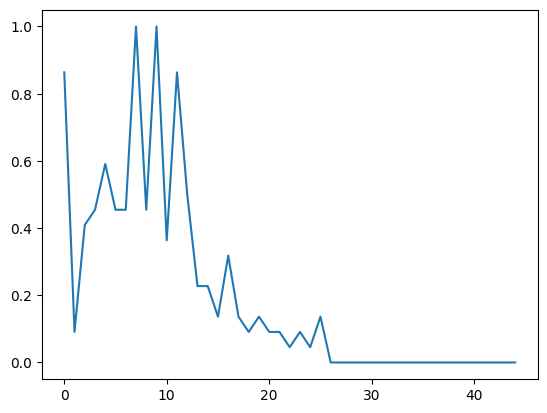

In [20]:
plt.plot(clusters_per_layer[300]/clusters_per_layer[300].max())
plt.show()

In [21]:
clusters_per_layer = clusters_per_layer / clusters_per_layer.max(axis=1).reshape(len(clusters_per_layer), 1)
e_per_layer = e_per_layer / e_per_layer.max(axis=1).reshape(len(e_per_layer), 1)

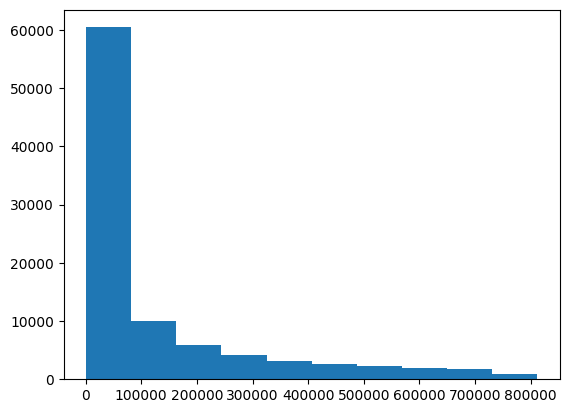

In [24]:
plt.hist(visible_energy)
plt.show()

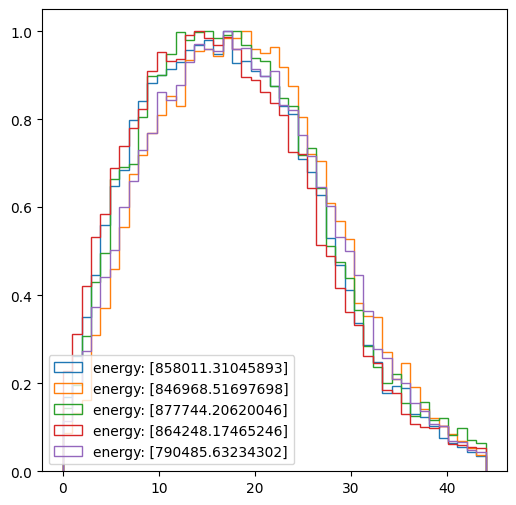

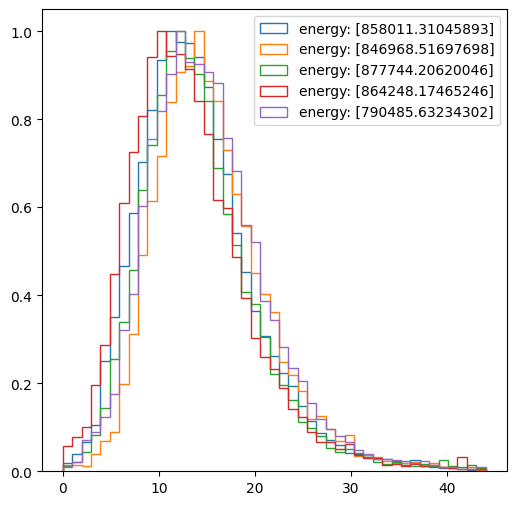

In [46]:
plt.figure(figsize=(6,6))
for i in range(90000, 90000+5):
    plt.hist(np.arange(45), weights=clusters_per_layer[i, :], label=f'energy: {energy[i]}', histtype='step', bins=45)
plt.legend()
plt.show()

plt.figure(figsize=(6,6))
for i in range(90000, 90000+5):
    plt.hist(np.arange(45), weights=e_per_layer[i, :], label=f'energy: {energy[i]}', histtype='step', bins=45)
plt.legend()
plt.show()

In [25]:
df = pd.DataFrame([])

In [26]:
df = pd.DataFrame([])
df['energy'] = ( np.log(energy/energy.min()) / np.log(energy.max()/energy.min()) ).reshape(-1)
df['visible_energy'] = ( np.log(visible_energy/visible_energy.min()) / np.log(visible_energy.max()/visible_energy.min()) ).reshape(-1)
df['num_points'] = ( np.log((num_points+1)/num_points.min()) / np.log(num_points.max()/num_points.min()) ).reshape(-1)

df['clusters_per_layer'] = clusters_per_layer.tolist()
df['e_per_layer'] = e_per_layer.tolist()

In [27]:
df

,energy,visible_energy,num_points,clusters_per_layer,e_per_layer
0,0.016406,0.035284,0.001088,"[0.02702702702702703, 0.5405405405405406, 0.27...","[0.02015971578657627, 1.0, 0.30096346139907837..."
1,0.109922,0.081470,0.001088,"[0.24242424242424243, 0.3939393939393939, 0.96...","[0.29922646284103394, 1.0, 0.7123122811317444,..."
2,0.133287,0.067427,0.001088,"[0.5, 0.5, 0.5833333333333334, 0.5833333333333...","[0.9326252937316895, 0.651772677898407, 0.5126..."
3,0.097859,0.081972,0.001088,"[0.08, 0.36, 0.2, 0.56, 0.68, 0.28, 0.68, 0.96...","[0.015442951582372189, 1.0, 0.0737369731068611..."
4,0.098692,0.036156,0.001088,"[0.23076923076923078, 0.3076923076923077, 0.53...","[0.13203562796115875, 0.730049192905426, 0.254..."
...,...,...,...,...,...
93055,0.995288,0.990728,0.993569,"[0.09870550161812297, 0.21844660194174756, 0.3...","[0.011384518817067146, 0.0329514779150486, 0.0..."
93056,0.998806,0.988227,0.995232,"[0.17274167987321712, 0.27258320126782887, 0.3...","[0.021251386031508446, 0.04504545032978058, 0...."
93057,0.996561,0.989462,0.996710,"[0.1035031847133758, 0.18471337579617833, 0.27...","[0.013867212459445, 0.049144282937049866, 0.05..."
93058,0.992803,0.985423,0.997196,"[0.17953020134228187, 0.31543624161073824, 0.3...","[0.026625527068972588, 0.056252602487802505, 0..."


In [28]:
visible_energy.min() * (np.e ** (df.visible_energy.values * np.log(visible_energy.max() / visible_energy.min())))


array([  1198.9194,   1637.9515,   1489.6942, ..., 755730.8   ,
       735388.    , 702656.4   ], dtype=float32)

In [29]:
visible_energy

array([  1198.9194,   1637.9517,   1489.6942, ..., 755730.9   ,
       735388.2   , 702656.5   ], dtype=float32)

In [30]:
num_points.min() * (np.e ** (df.num_points.values * np.log(num_points.max() / num_points.min()))) - 1


array([  201.,   201.,   201., ..., 18919., 18961., 19206.])

In [31]:
num_points

array([  201,   201,   201, ..., 18919, 18961, 19206])

In [47]:
dataset = torch.utils.data.TensorDataset(
    torch.tensor(df.energy.values), 
    torch.tensor(df.visible_energy.values),
    torch.tensor(df.num_points.values),
    torch.tensor(df.e_per_layer),
    torch.tensor(df.clusters_per_layer)
    )

In [48]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=params["batch_size"], shuffle=params["shuffle"], pin_memory=True)


In [49]:
batch = next(iter(train_loader))

In [52]:
# items in batch: (insident energy, visible_energy, num_points, e_per_layer, clusters_per_layer)
for item in batch:
    print(item.shape)

torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 45])
torch.Size([512, 45])


In [53]:
from tqdm import tqdm

In [193]:
lr = 1e-6
                   
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

model.train()
                   

torch.manual_seed(41)

losses = []
# for epoch in range(301, params["epochs"]+1):
for epoch in range(1):
    input_list = []
#     for batch_idx, (mu, logvar, e, theta, e_sum) in enumerate(train_loader):
    for batch_idx, (energy, visible_energy, num_points, e_per_layer, clusters_per_layer) in enumerate(tqdm(train_loader)):

        E_true = energy.view(-1, 1).to(device).float()
        energy_sum = visible_energy.view(-1,1).to(device).float()
        num_points = num_points.view(-1,1).to(device).float()
        e_per_layer = e_per_layer.to(device).float()
        clusters_per_layer = clusters_per_layer.to(device).float()
   
        

        input_data = torch.cat((energy_sum, num_points, e_per_layer, clusters_per_layer), 1)   #### input data structure required for network with additional features in latent space (e.g. Esum)
        
        #input_data = torch.cat((z), 1)
        #input_data = z

        optimizer.zero_grad()

        # try to add context for conditioning by concatenating 
        context = E_true
        #print(theta_true.size())
        
        #nll = -distribution.condition(E_true).log_prob(input_data) ## solution   # does this work, or do need spearate .condition for each label?
        
        if np.any(np.isnan(input_data.clone().detach().cpu().numpy())) == True:
            print('Nans in the training data!')
            
        #### check if any of the weights are nans
        #for param in model.parameters():
        #    if np.any(np.isnan(param.weight.clone().detach().cpu().numpy())) == True:
        #        print('Weights are nan!')
            
        nll = -distribution.condition(context).log_prob(input_data)
        loss = nll.mean()
        #print(loss.item())
        loss.backward()

        optimizer.step() 

        distribution.clear_cache()
        
        input_list.append(input_data.detach().cpu().numpy())

    print(epoch, loss.item())
    losses.append(loss.item())
    #############################
    # Log to COMET ML
    #############################

    if epoch%10 == 0:
        torch.save(
            {'model': model.state_dict()}, 
            f'/beegfs/desy/user/akorol/logs/ShowerFlow_new_f_{epoch}.pth'
        )



100%|██████████| 182/182 [00:30<00:00,  5.97it/s]


0 -263.2835998535156


In [10]:
ls /beegfs/desy/user/akorol/logs

point-cloud/        ShowerFlow_400.pth      ShowerFlow_new_270.pth
ShowerFlow_170.pth  ShowerFlow_410.pth      ShowerFlow_new_280.pth
ShowerFlow_180.pth  ShowerFlow_420.pth      ShowerFlow_new_290.pth
ShowerFlow_190.pth  ShowerFlow_430.pth      ShowerFlow_new_300.pth
ShowerFlow_200.pth  ShowerFlow_440.pth      ShowerFlow_new_30.pth
ShowerFlow_210.pth  ShowerFlow_new_100.pth  ShowerFlow_new_310.pth
ShowerFlow_220.pth  ShowerFlow_new_10.pth   ShowerFlow_new_320.pth
ShowerFlow_230.pth  ShowerFlow_new_110.pth  ShowerFlow_new_330.pth
ShowerFlow_240.pth  ShowerFlow_new_120.pth  ShowerFlow_new_340.pth
ShowerFlow_250.pth  ShowerFlow_new_130.pth  ShowerFlow_new_350.pth
ShowerFlow_260.pth  ShowerFlow_new_140.pth  ShowerFlow_new_360.pth
ShowerFlow_270.pth  ShowerFlow_new_150.pth  ShowerFlow_new_370.pth
ShowerFlow_280.pth  ShowerFlow_new_160.pth  ShowerFlow_new_380.pth
ShowerFlow_290.pth  ShowerFlow_new_170.pth  ShowerFlow_new_390.pth
ShowerFlow_300.pth  ShowerFlow_new_180.pth  ShowerFlow_new_400.

In [54]:
checkpoint = torch.load('/beegfs/desy/user/akorol/logs/ShowerFlow_new_303.pth')

In [58]:
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [59]:
model.eval().to(device)

ModuleList(
  (0): ConditionalAffineCouplingTanH(
    (nn): ConditionalDenseNN(
      (layers): ModuleList(
        (0): Linear(in_features=47, out_features=920, bias=True)
        (1): Linear(in_features=920, out_features=920, bias=True)
        (2): Linear(in_features=920, out_features=92, bias=True)
      )
      (f): ReLU()
    )
  )
  (1): ConditionalAffineCouplingTanH(
    (nn): ConditionalDenseNN(
      (layers): ModuleList(
        (0): Linear(in_features=47, out_features=920, bias=True)
        (1): Linear(in_features=920, out_features=920, bias=True)
        (2): Linear(in_features=920, out_features=92, bias=True)
      )
      (f): ReLU()
    )
  )
  (2): ConditionalAffineCouplingTanH(
    (nn): ConditionalDenseNN(
      (layers): ModuleList(
        (0): Linear(in_features=47, out_features=920, bias=True)
        (1): Linear(in_features=920, out_features=920, bias=True)
        (2): Linear(in_features=920, out_features=92, bias=True)
      )
      (f): ReLU()
    )
  )
  (3

In [60]:
low_log = np.log10(1000)  # convert to log space
high_log = np.log10(1000000)  # convert to log space
uniform_samples = np.random.uniform(low_log, high_log, 100000)

# apply exponential function (base 10)
log_uniform_samples = np.power(10, uniform_samples)
log_uniform_samples = ( np.log(log_uniform_samples/log_uniform_samples.min()) / np.log(log_uniform_samples.max()/log_uniform_samples.min()) ).reshape(-1)
cond_E = torch.tensor(log_uniform_samples).view(100000, 1).to(device).float()

# energy_sum, e_per_layer, clusters_per_layer
with torch.no_grad():
    samples = distribution.condition(cond_E).sample(torch.Size([100000, ])).cpu().numpy() #.detach().numpy
    
# energy_sum = samples[:, 0] * 800000
# e_ins = cond_E.cpu().numpy().reshape(-1)*1000*1000

In [114]:
samples.shape

(100000, 92)

In [ ]:
visible_energy, num_points, e_per_layer, clusters_per_layer

In [61]:
energy_sum = visible_energy_true.min() * (np.e ** (samples[:, 0] * np.log(visible_energy_true.max() / visible_energy_true.min())))

In [62]:
e_ins = cond_E.cpu().numpy().reshape(-1)
e_ins = energy.min() * (np.e ** (e_ins * np.log(energy.max() / energy.min())))

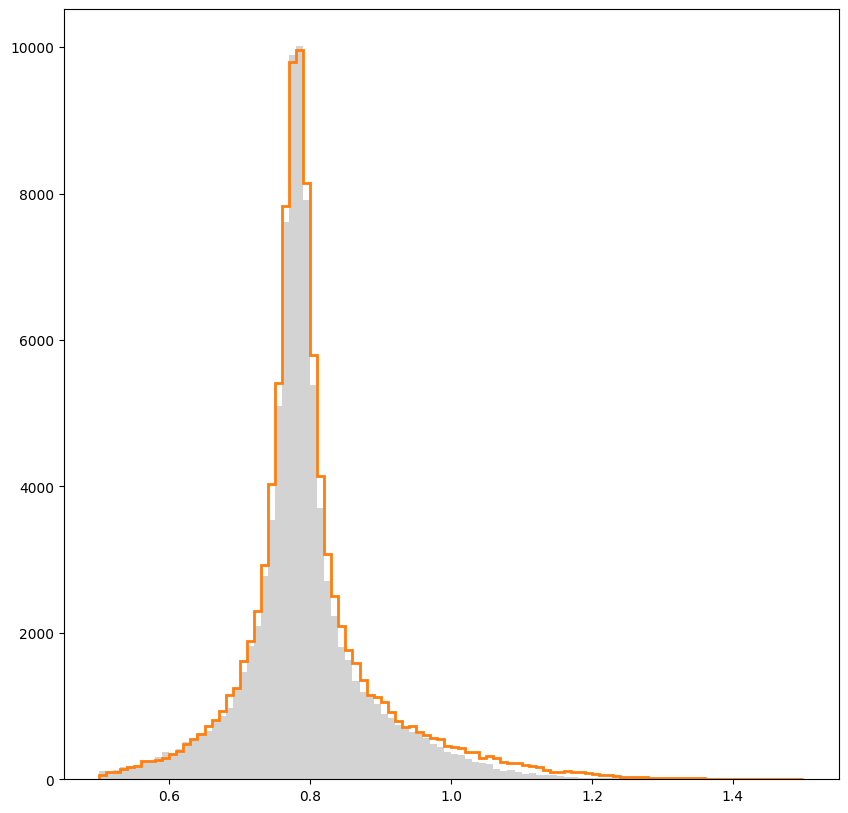

In [65]:
plt.figure(figsize=(10,10))
# h = plt.hist(visible_energy_true/energy_true.reshape(-1), bins=100, range=(0.5, 1.5), color='lightgrey', density=1)
# plt.hist(energy_sum/e_ins, bins=h[1], histtype='step', lw=2, color='tab:orange', density=1)
h = plt.hist(visible_energy_true/energy_true.reshape(-1), bins=100, range=(0.5, 1.5), color='lightgrey')
h2 = plt.hist(energy_sum/e_ins, bins=h[1], histtype='step', lw=2, color='tab:orange')
plt.show()

In [68]:
# separation power
ratios = (h[0] - h2[0])**2 / (h[0] + h2[0])

S2 = ratios[~np.isnan(ratios)].sum()/2
print(S2/200000)

0.003063479589590828


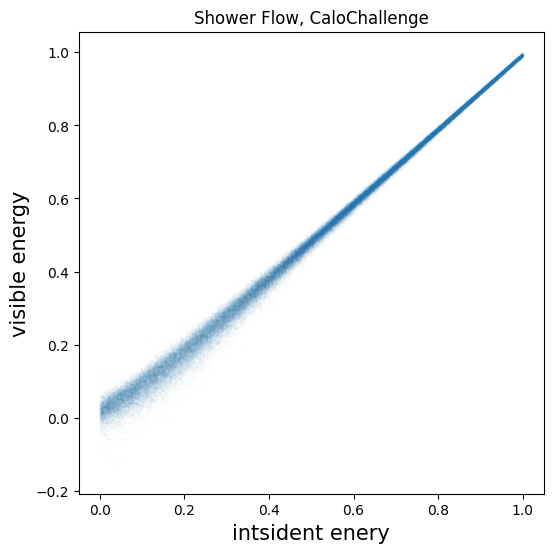

In [69]:
plt.figure(figsize=(6, 6))
plt.scatter(cond_E.cpu().numpy().reshape(-1), samples[:, 0], s=0.01, alpha=0.1)
plt.xlabel('intsident enery', fontsize=15)
plt.ylabel('visible energy', fontsize=15)
# plt.xlim(-150,3900)
# plt.ylim(-150,2500)
plt.title('Shower Flow, CaloChallenge')
plt.show()

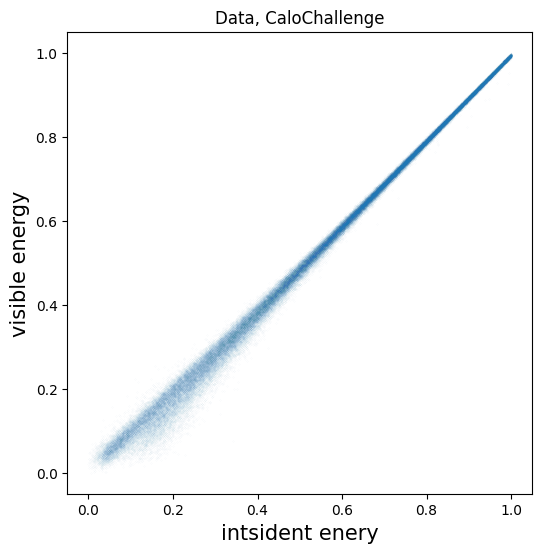

In [75]:
plt.figure(figsize=(6, 6))
plt.scatter(df.energy.values, df.visible_energy.values, s=0.01, alpha=0.1)
plt.xlabel('intsident enery', fontsize=15)
plt.ylabel('visible energy', fontsize=15)
# plt.xlim(-150,3900)
# plt.ylim(-150,2500)
plt.title('Data, CaloChallenge')
plt.show()

In [88]:
def invers_transform_energy(energy):
    energy_min, energy_max = 944.6402, 811494.44 # min max energy in the dataset
    return energy_min * (np.e ** (energy * np.log(energy_max / energy_min)))

def invers_transform_points(n_points):
    points_min, points_max = 201, 19206 # min max number of points in the dataset
    return points_min * (np.e ** (n_points * np.log(points_max / points_min)))

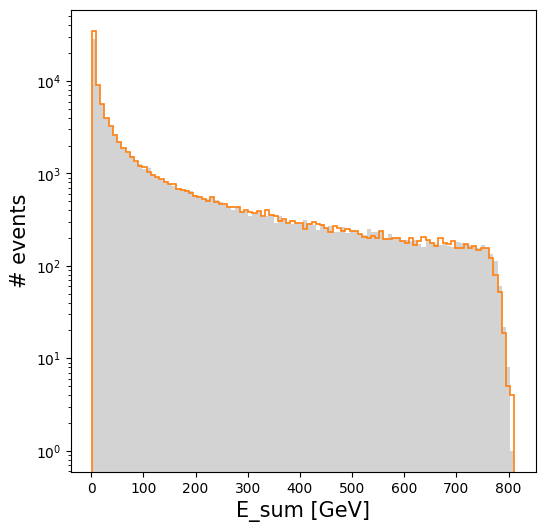

In [132]:
plt.figure(figsize=(6, 6))
h = plt.hist(invers_transform_energy(df.visible_energy.values)/1000, bins=100, color='lightgray')
plt.hist(invers_transform_energy(samples[:, 0])/1000, bins=h[1], histtype='step', color='tab:orange', lw=1.2)

plt.yscale('log')
plt.xlabel('E_sum [GeV]', fontsize=15)
plt.ylabel('# events', fontsize=15)
plt.show()

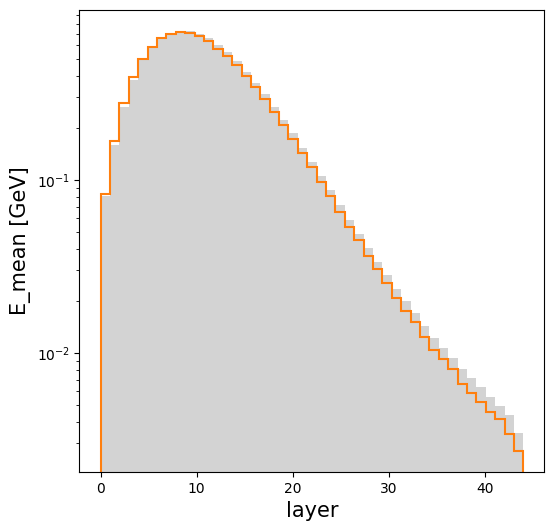

In [90]:
plt.figure(figsize=(6, 6))
h = plt.hist(np.arange(45), weights=e_per_layer.mean(axis=0), bins=45, color='lightgray')
plt.hist(np.arange(45), weights=samples[:, 2:47].mean(axis=0), bins=h[1], histtype='step', lw=1.5, color='tab:orange')
plt.yscale('log')
plt.xlabel('layer', fontsize=15)
plt.ylabel('E_mean [GeV]', fontsize=15)
plt.show()

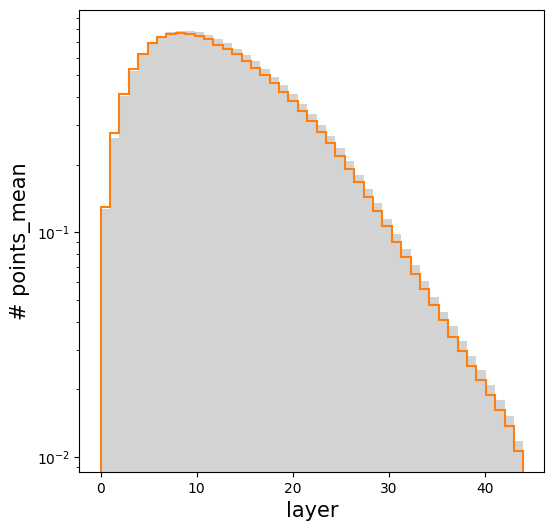

In [91]:
plt.figure(figsize=(6, 6))
h = plt.hist(np.arange(45), weights=clusters_per_layer.mean(axis=0), bins=45, color='lightgray')
plt.hist(np.arange(45), weights=samples[:, 47:].mean(axis=0), bins=h[1], histtype='step', lw=1.5, color='tab:orange')
plt.yscale('log')
plt.xlabel('layer', fontsize=15)
plt.ylabel('# points_mean', fontsize=15)
plt.show()

In [94]:
e_per_layer = np.load('e_per_layer.npy')
clusters_per_layer = np.load('clusters_per_layer.npy')

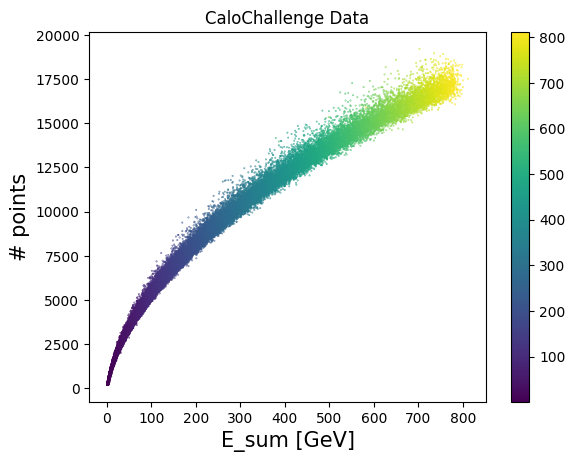

In [108]:
### plt.figure(figsize=(7, 6))
plt.scatter(e_per_layer.sum(axis=1)/1000, clusters_per_layer.sum(axis=1), s=0.1, c=invers_transform_energy(df.energy)/1000)
# plt.scatter(samples[:, 1:46].sum(axis=1)*40, samples[:, 46:].sum(axis=1)*600, color='tab:orange', s=0.1, alpha=0.1)
plt.xlabel('E_sum [GeV]', fontsize=15)
plt.ylabel('# points', fontsize=15)
plt.title('CaloChallenge Data')
plt.colorbar()
plt.show()

In [128]:
num_points_gen = invers_transform_points(samples[:, 1])
vis_energy_gen = invers_transform_energy(samples[:, 0])

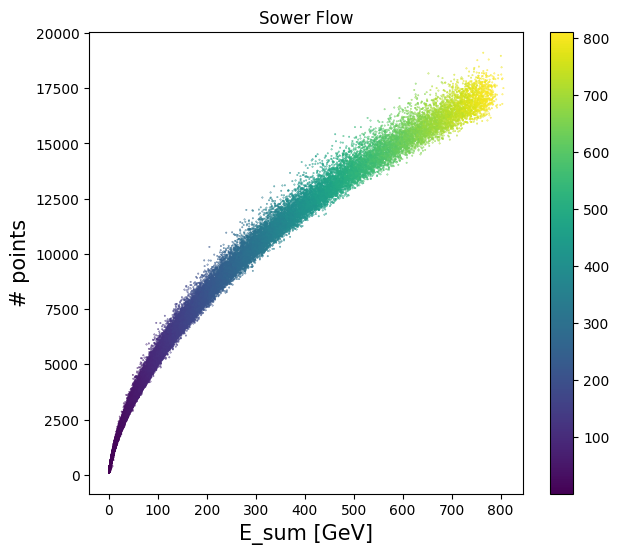

In [130]:
plt.figure(figsize=(7, 6))
plt.scatter(vis_energy_gen/1000, num_points_gen, c=invers_transform_energy(cond_E.cpu().numpy().reshape(-1))/1000, s=0.1)
plt.xlabel('E_sum [GeV]', fontsize=15)
plt.ylabel('# points', fontsize=15)
plt.title('Sower Flow')
plt.colorbar()
plt.show()